### Imports

In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import groupby
from scipy.special import comb, gamma
import scipy.stats as stats

### Functions

Functions from the previous lab:

In [2]:
def get_data_from_csv_file(file_path: str) -> list:
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        data = [float(value) for row in reader for value in row]
                   
    return data

def remove_outliers(data: list, threshold: float) -> tuple[list, list]:
    data = np.array(data)

    mean = sum(data) / len(data)
    variance = sum([(x - mean) ** 2 for x in data]) / len(data)
    deviation = np.sqrt(variance)
 
    z_scores = np.abs((data - mean) / deviation)

    outliers = [x for x, z in zip(data, z_scores) if z > threshold]
    cleaned_data = [x for x, z in zip(data, z_scores) if z <= threshold]
    
    return cleaned_data, outliers

Function for getting statistical series from simple dataset:

In [3]:
def get_statistical_series(data: list, bins=15) -> list[tuple, float, float, float]:
    n = len(data)

    data.sort()

    a, b = data[0], data[-1]
    l = (b - a) / bins

    data_with_m = Counter(data).items()

    intervals_with_m = groupby(data_with_m, key=lambda x: int(x[0] / l) * l)

    statistical_series = [(interval, sum(x[1] for x in m) / n)  for interval, m in intervals_with_m]
    
    for interval, p in statistical_series:
        print(f'[{interval}, {interval + l}): {p}')

    return statistical_series, l, a, b

Function for getting the characteristics:

In [4]:
def get_the_characteristics(statistical_series: list[tuple], l: float) -> tuple[float, float, float]:    
    mean = sum((interval + l / 2) * p for interval, p in statistical_series)
    variance = sum((interval + l / 2) ** 2 * p for interval, p in statistical_series) - mean ** 2
    deviation = np.sqrt(variance)

    return mean, variance, deviation

Functions for getting probability density function of the typical distributions with k (count of parameters): 

In [5]:
def normal_distribution(mean: float, variance: float, deviation: float):    
    return lambda x: 1 / (deviation * np.sqrt(2 * np.pi)) * np.exp(-(x - mean) ** 2 / (2 * variance)), 2

def exponential_distribution(mean: float):
    intensity = 1 / mean
    if intensity <= 0:
        return None
    else:
        return lambda x: intensity * math.exp(-intensity * x) if x >= 0 else 0, 1

def uniform_distribution(mean: float, variance: float):
    b = (3 * variance) ** 0.5 + mean
    a = 2 * mean - b   
    return lambda x: 1 / (b - a) if a <= x <= b else 0, 2 

def geometric_distribution(mean: float):
    p = 1 / mean
    if p > 1 or p <= 0:
        return None
    else:
        q = 1 - p
        return lambda x: q ** x * p if x >= 0 else 0, 3

def binomial_distribution(mean: float, n: int):
    p = mean / n
    if p > 1 or p < 0 or n < 0:
        return None
    else:
        return lambda x: comb(n, x) * (p ** x) * ((1 - p) ** (n - x)) if x >= 0 else 0, 2

def poisson_distribution(mean: float):
    return lambda x: math.exp(-mean) * (mean ** x) / gamma(x + 1) if x >= 0 else 0, 1

Function for plotting some distribition and data histogram:

In [6]:
def plot_distribution(distribution: str, distribution_function, data: list, bins=15) -> None:
    data.sort()
    a, b = data[0], data[-1]
    
    if distribution in ('Normal', 'Exponential', 'Uniform'):
        x = np.linspace(a, b, 1000)
    elif distribution in ('Geometric', 'Binomial', 'Poisson'):
        x = list(range(int(a), int(b)))
    else:
        return

    f_x = [distribution_function(val) for val in x]

    _, ax1 = plt.subplots()
    ax1.hist(data, bins=bins, color='pink', edgecolor='hotpink')
    ax2 = ax1.twinx()
    ax2.plot(x, f_x, color='mediumblue')

    plt.title(f'{distribution} Distribution')
    plt.show()

Function for checking pearson criterion:

In [7]:
def pearson_criterion(statistical_series: list[tuple], l: float, distribution_function, k: int):
    n = len(statistical_series)
    r = n - k - 1

    chi_2 = 0

    for stat in statistical_series:
        p_i = distribution_function(stat[0] + l / 2) * l
        if p_i != 0:
            chi_2 += n * (stat[1] - p_i) ** 2 / p_i
        else: 
            chi_2 += n * (stat[1] - p_i) ** 2 / 10e-10
    p_value = 1 - stats.chi2.cdf(chi_2, df=r)

    return chi_2, p_value

Function for checking kolmogorov criterion:

In [8]:
def get_p(lmbda: float):
    P_TABLE = {0.0: 1.000, 0.1: 1.000, 0.2: 1.000, 0.3: 1.000, 0.4: 0.997,
            0.5: 0.964, 0.6: 0.864, 0.7: 0.711, 0.8: 0.544, 0.9: 0.393,
            1.0: 0.270, 1.1: 0.178, 1.2: 0.112, 1.3: 0.068, 1.4: 0.040,
            1.5: 0.022, 1.6: 0.012, 1.7: 0.006, 1.8: 0.003, 1.9: 0.002,
            2.0: 0.001, 3.0: 0.000}
    
    closest_key = min(P_TABLE.keys(), key=lambda x: abs(x - lmbda))
    return P_TABLE[closest_key]

def kolmogorov_criterion(statistical_series: list[tuple], distribution_function, l: float):
    x, y = [], [] 
    for interval, p in statistical_series:
        if len(y) == 0:
            y.append(p)
        else:
            y.append(y[-1] + p)
        x.append(interval)
    
    t_x, t_y = x.copy(), []
    for interval in t_x:
        p = distribution_function(interval + l / 2) * l
        if len(t_y) == 0:
            t_y.append(p)
        else:
            t_y.append(t_y[-1] + p)        
    t_y = [t_val / t_y[-1] for t_val in t_y]

    plt.plot(x, y, color='mediumblue')
    plt.plot(t_x, t_y, color='hotpink')
    plt.title('Kolmogorov')
    plt.show()    
    
    D = max([abs(val - t_val) for val, t_val in zip(y, t_y)])
    lmbda = len(statistical_series) ** 0.5 * D
    p = get_p(lmbda)
    
    return lmbda, p

### Testing

#### Set 1 from the last lab

In [9]:
data = get_data_from_csv_file('../lab1/set_1.csv')

In [10]:
data, outliers = remove_outliers(data, 4)
print('Detected outliers: ', outliers)
print(len(outliers))

Detected outliers:  [17.0, 17.0, 17.0, 30.0, 20.0, 17.0, 21.0, 44.0, 18.0, 30.0, 17.0, 29.0, 28.0, 29.0, 27.0, 22.0, 19.0, 18.0, 18.0, 24.0, 19.0, 32.0, 18.0, 22.0, 17.0, 31.0, 21.0, 19.0, 17.0, 30.0, 37.0, 28.0, 19.0, 28.0, 29.0, 17.0, 24.0, 18.0, 28.0, 17.0, 29.0, 31.0, 22.0, 33.0, 17.0, 17.0, 30.0, 22.0, 28.0, 17.0, 20.0, 17.0, 17.0, 22.0, 19.0, 32.0, 28.0, 32.0, 17.0, 18.0, 28.0, 33.0, 21.0, 19.0, 32.0, 21.0, 18.0, 18.0, 28.0, 18.0, 25.0, 29.0, 29.0, 18.0, 19.0, 18.0, 17.0, 22.0, 30.0, 17.0, 25.0, 18.0, 28.0, 30.0, 32.0, 19.0, 17.0, 31.0, 19.0, 19.0, 28.0, 17.0, 28.0, 17.0, 29.0, 31.0, 18.0, 18.0, 32.0, 17.0, 21.0, 34.0, 31.0, 17.0, 42.0, 28.0, 17.0, 17.0, 17.0, 19.0, 32.0, 17.0, 21.0, 18.0, 19.0, 39.0, 28.0, 17.0, 30.0, 29.0, 30.0, 17.0, 34.0, 21.0, 33.0, 28.0, 19.0, 24.0, 28.0, 21.0, 31.0, 19.0, 23.0, 18.0, 18.0, 29.0, 18.0, 30.0, 28.0, 19.0, 30.0, 35.0, 32.0, 22.0, 18.0, 17.0, 29.0, 28.0, 29.0, 34.0, 17.0, 32.0, 20.0, 38.0, 28.0, 19.0, 17.0, 21.0, 33.0, 17.0, 17.0, 22.0, 28.0, 3

In [11]:
statistical_series, l, a, b = get_statistical_series(data)

[1.0, 2.0): 0.29983195644955174
[2.0, 3.0): 0.20798156552189095
[3.0, 4.0): 0.14680163817305467
[4.0, 5.0): 0.1054951247245394
[5.0, 6.0): 0.07142354018454602
[6.0, 7.0): 0.05083568963261856
[7.0, 8.0): 0.03549039535515552
[8.0, 9.0): 0.024844282997413942
[9.0, 10.0): 0.01729741695931736
[10.0, 11.0): 0.013181859346542027
[11.0, 12.0): 0.00975055092122078
[12.0, 13.0): 0.0061783676631884
[13.0, 14.0): 0.004155807564978516
[14.0, 15.0): 0.0030187464152386318
[15.0, 16.0): 0.0020728725384638606
[16.0, 17.0): 0.0016401855522796566


In [12]:
mean, variance, deviation = get_the_characteristics(statistical_series, l)

print('Mean =', mean)
print('Variance =', variance)
print('Deviation =', deviation)

Mean = 3.810015194356956
Variance = 7.09849909817021
Deviation = 2.6643008647992836


Check if this is the normal distribution.

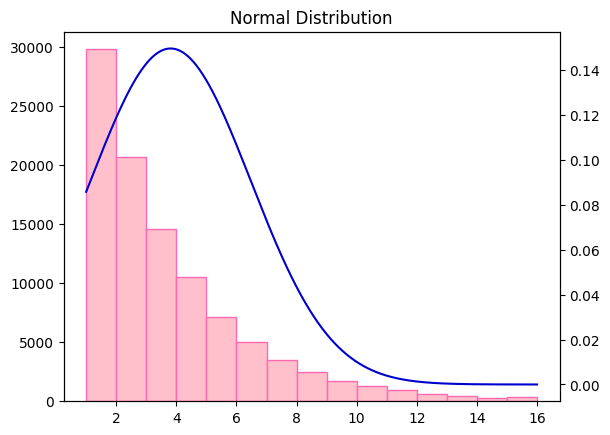

In [13]:
distribution, distribution_function, k = 'Normal', *normal_distribution(mean, variance, deviation)
plot_distribution(distribution, distribution_function, data)

In [14]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 44.098504018097046
p_value = 2.9556578864720073e-05


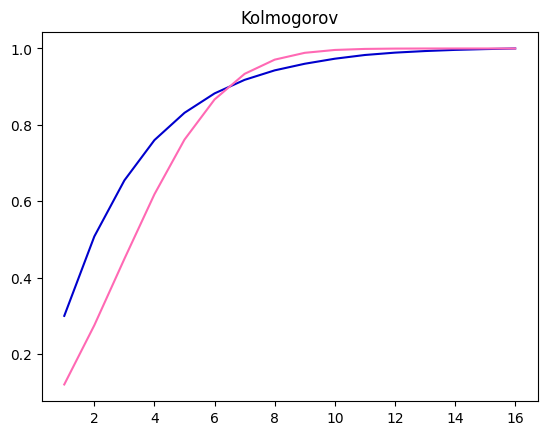

lmbda = 0.9302808143971022
p = 0.393


In [15]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)

Check if this is the exponential distribution.

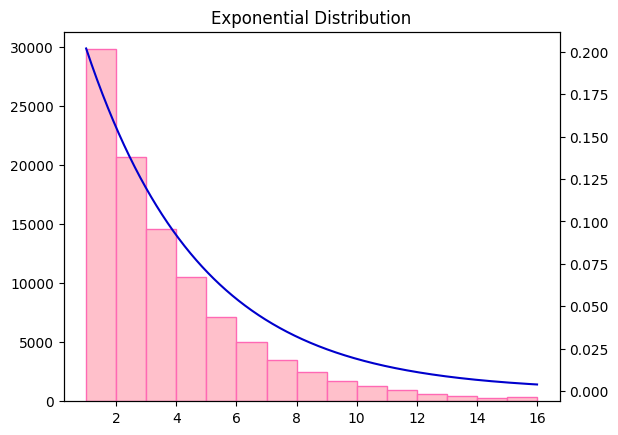

In [16]:
distribution, distribution_function, k = 'Exponential', *exponential_distribution(mean)
plot_distribution(distribution, distribution_function, data)

In [17]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 2.5379153839313435
p_value = 0.999650039675267


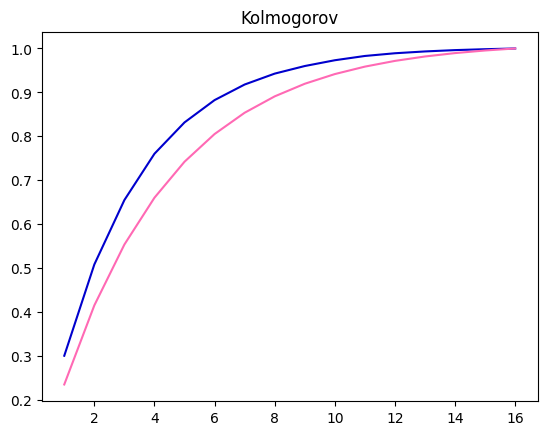

lmbda = 0.4053641582047751
p = 0.997


In [18]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)

#### Normal random set

In [19]:
data = np.random.normal(3, 6, size=10000)

In [20]:
statistical_series, l, a, b = get_statistical_series(data)

[-17.418673081564666, -14.515560901303889): 0.0002
[-14.515560901303887, -11.61244872104311): 0.0013
[-11.61244872104311, -8.709336540782333): 0.0064
[-8.709336540782333, -5.806224360521556): 0.0189
[-5.806224360521555, -2.9031121802607776): 0.0478
[-2.9031121802607776, 0.0): 0.0872
[0.0, 2.9031121802607776): 0.3293
[2.9031121802607776, 5.806224360521555): 0.1887
[5.806224360521555, 8.709336540782333): 0.1517
[8.709336540782333, 11.61244872104311): 0.0957
[11.61244872104311, 14.515560901303887): 0.0451
[14.515560901303887, 17.418673081564666): 0.0187
[17.418673081564666, 20.321785261825443): 0.0072
[20.321785261825443, 23.22489744208622): 0.0013
[23.22489744208622, 26.128009622346998): 0.0005


In [21]:
mean, variance, deviation = get_the_characteristics(statistical_series, l)

print('Mean =', mean)
print('Variance =', variance)
print('Deviation =', deviation)

Mean = 3.8802997401365555
Variance = 26.055352222184837
Deviation = 5.104444359789304


Check if this is the normal distribution.

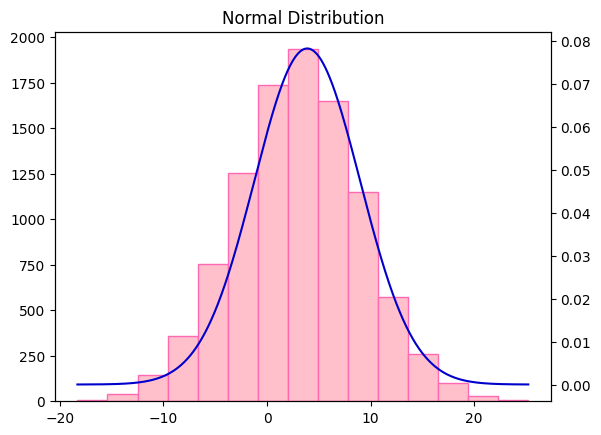

In [22]:
distribution, distribution_function, k = 'Normal', *normal_distribution(mean, variance, deviation)
plot_distribution(distribution, distribution_function, data)

In [23]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 1.8399316892790647
p_value = 0.9996147052829528


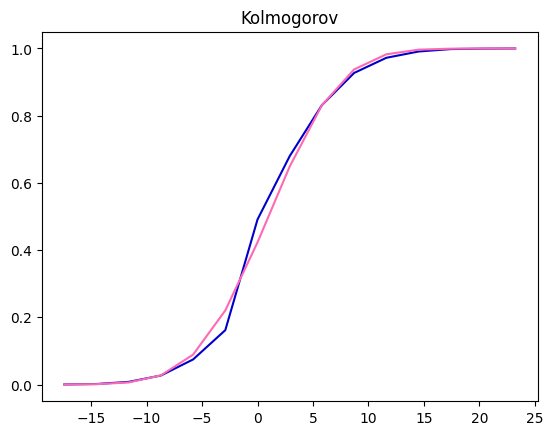

lmbda = 0.2635714270056242
p = 1.0


In [24]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)

Check if this is the uniform distribution.

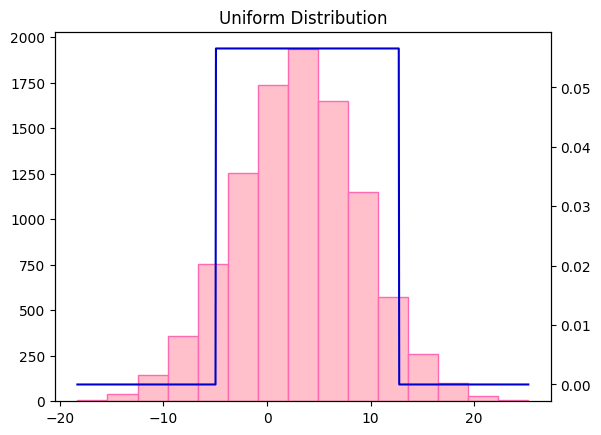

In [25]:
distribution, distribution_function, k = 'Uniform', *uniform_distribution(mean, variance)
plot_distribution(distribution, distribution_function, data)

In [26]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 42560704.767427176
p_value = 0.0


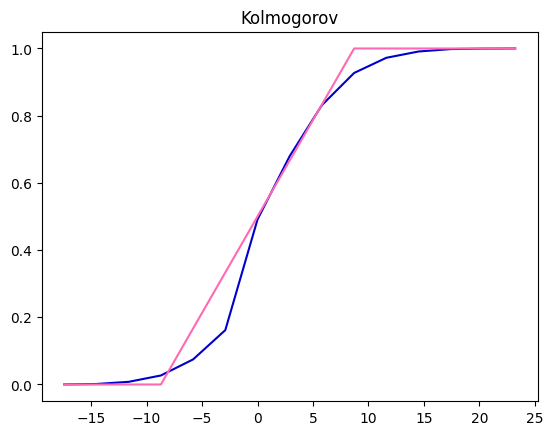

lmbda = 0.6643457433194455
p = 0.711


In [27]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)

#### Geometric random set

In [28]:
data = np.random.normal(3, 6, size=10000)

In [29]:
statistical_series, l, a, b = get_statistical_series(data)

[-17.923638258784454, -14.936365215653712): 0.0003
[-14.93636521565371, -11.949092172522969): 0.0011
[-11.949092172522969, -8.961819129392227): 0.0045
[-8.961819129392227, -5.974546086261485): 0.0151
[-5.974546086261484, -2.987273043130742): 0.0435
[-2.987273043130742, 0.0): 0.096
[0.0, 2.987273043130742): 0.3352
[2.987273043130742, 5.974546086261484): 0.1902
[5.974546086261484, 8.961819129392227): 0.1442
[8.961819129392227, 11.949092172522969): 0.0999
[11.949092172522969, 14.93636521565371): 0.0448
[14.93636521565371, 17.923638258784454): 0.0186
[17.923638258784454, 20.910911301915196): 0.0049
[20.910911301915196, 23.898184345045937): 0.0014
[23.898184345045937, 26.88545738817668): 0.0003


In [30]:
mean, variance, deviation = get_the_characteristics(statistical_series, l)

print('Mean =', mean)
print('Variance =', variance)
print('Deviation =', deviation)

Mean = 3.998464968230498
Variance = 26.104058842581644
Deviation = 5.1092131334073


Check if this is the poisson distribution.

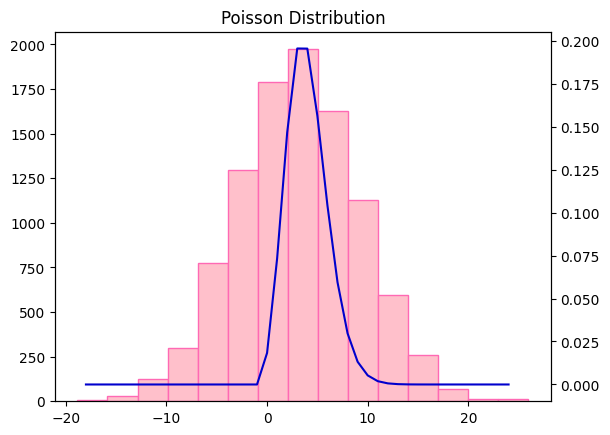

In [31]:
distribution, distribution_function, k = 'Poisson', *poisson_distribution(mean)
plot_distribution(distribution, distribution_function, data)

In [32]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 171153953.70022273
p_value = 0.0


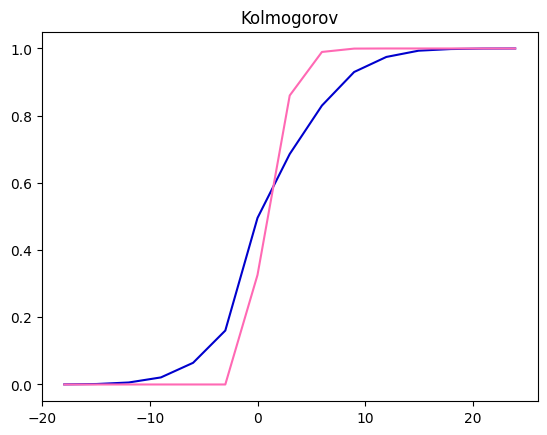

lmbda = 0.6745347190601303
p = 0.711


In [33]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)

Check if this is the geometric distribution.

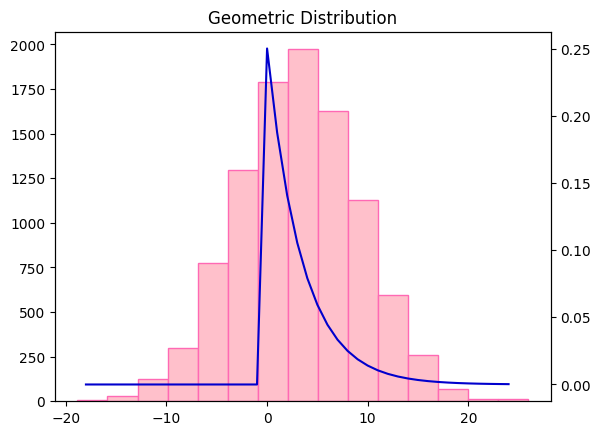

In [34]:
distribution, distribution_function, k = 'Geometric', *geometric_distribution(mean)
plot_distribution(distribution, distribution_function, data)

In [35]:
chi_2, p_value = pearson_criterion(statistical_series, l, distribution_function, k)
print('chi_2 =', chi_2)
print('p_value =', p_value)

chi_2 = 170367154.07203996
p_value = 0.0


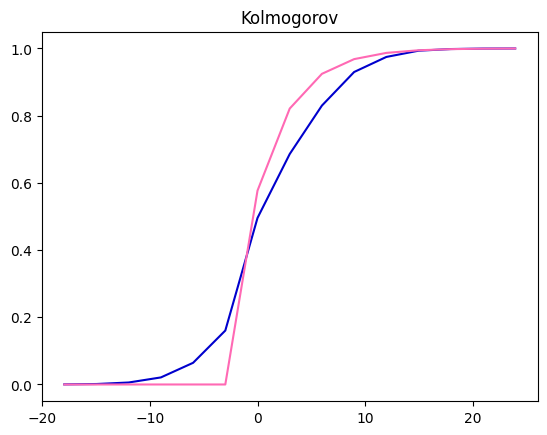

lmbda = 0.6216138270662904
p = 0.864


In [36]:
lmbda, p = kolmogorov_criterion(statistical_series, distribution_function, l)
print('lmbda =', lmbda)
print('p =', p)